In [ ]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
import spacy
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
import os
import os
import json




### Reading all excel files individually, to do analysis and cleaning data

In [2]:
df_auto = pd.read_excel(
    "Interview Sample Data.xlsx",
    sheet_name="Auto"
)

# print(df_auto.head())


In [3]:
df_wc = pd.read_excel(
    "Interview Sample Data.xlsx",
    sheet_name="WC"
)

# print(df_auto.head())

In [4]:
df_gl = pd.read_excel(
    "Interview Sample Data.xlsx",
    sheet_name="GL"
)

# print(df_auto.head())

### Determine the number of unique coverage types for all LOB

In [5]:
y = df_auto["Coverage Type"]

num_labels = y.nunique()
print(num_labels)

32


In [6]:
y = df_wc["Coverage Type"]

num_labels = y.nunique()
print(num_labels)

33


In [7]:
y = df_gl["Coverage Type"]

num_labels = y.nunique()
print(num_labels)

21


### Consolidating the fine grained coverages into higher categories
#### Normalizing, Cleaning the labels
#### Adding a static LOB column for each sheet

In [8]:
import re

def normalize_coverage(text, auto_coverage_map):
    if not isinstance(text, str):
        return text  

    text_lower = text.lower()

    for normalized_label, patterns in auto_coverage_map.items():
        for pattern in patterns:
            if re.search(pattern, text_lower):
                return normalized_label

    
    return "Other"

Auto Liability, Collision, Comprehensive, Medical/PIP, UM/UIM, Physical damage, other

Auto Liability - Liablity, Liab,al ,Garage Keepers
Collision - Collision,coll
Comprehensive - Comprehensive, comp, phys dam, pd only,Property Damage Only
Medical/PIP - PIP,medpay,Med Pay ,No Fault
UM/UIM - UIM,UM,Underinsrd, Uninsrd 


In [9]:
auto_coverage_map = {
    "Auto Liability": [
        r"\bliability\b",
        r"\bliab\b",
        r"\bal\b",
        r"garage\s*keepers",
        r"\bliablity\b"
    ],
    "Auto Collision": [
        r"\bcollison\b",
        r"\bcoll\b",
        r"\bcollision\b"
    ],
    "Auto Comprehensive": [
        r"\bcomprehenive\b",
        r"\bcomprehensive\b",
        r"\bcomp\b",
        r"\bphys\s*dam\b",
        r"\bpd\s*only\b",
        r"\bproperty\s*damage\s*only\b"
    ],
    "Auto Medical_PIP": [
        r"\bpip\b",
        r"\bmedpay\b",
        r"\bmed\s*pay\b",
        r"\bno\s*fault\b"
    ],
    "Auto UM_UIM": [
        r"\buim\b",
        r"\bum\b",
        r"\bunderinsrd\b",
        r"\buninsrd\b"
    ]
}


In [10]:
df_auto = df_auto[
    df_auto["Coverage Type"].notna() &
    (df_auto["Coverage Type"].str.strip() != "")
]

df_auto['Coverage Type'] = df_auto['Coverage Type'].astype(str).str.strip()
# df_auto = df_auto[~(df_auto["Coverage Type"].isna() | (df_auto["Coverage Type"] == ""))]
# df_auto.dropna(subset=["Coverage Type"], inplace=True)



df_auto['coverage_type_norm'] = df_auto['Coverage Type'].apply(
    lambda x: normalize_coverage(x, auto_coverage_map)
)


In [11]:
df_auto["coverage_type_norm"].value_counts(dropna=False)


coverage_type_norm
Auto Comprehensive    20
Auto Collision        14
Auto Liability        13
Auto Medical_PIP      12
Auto UM_UIM           11
Other                 11
Name: count, dtype: int64

In [12]:
df_auto.loc[df_auto["coverage_type_norm"] == "Other", "coverage_type_norm"] = "Auto_Other"


In [13]:
df_auto['lob']='Auto'

In [14]:
df_auto.head(5)

,Loss Description,Coverage Type,Date of Loss,Total Incurred,coverage_type_norm,lob
0,"Police rpt 21-838797; 911 called. Addr: 620 Elm St, Cleveland, OH 60616. Other party addr: 8379 Willow Way, Detroit, WI 60616. UM/UIM chk; clmt says H&R. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~42 mph. No airbag deploy; drivable to shop. Adj note: see CLM479201-83. DL# 787194506.",Med Pay,2018-08-18,16961.07,Auto Medical_PIP,Auto
1,"PD only; no inj. Plate CBC-6740; VIN N9U95A0ZUJYDRR85J. wdshld cracked; glass only. Weather: hail; roof & hood dents. Insd Robin Moore (DOB 11/25/2004, SSN 569-28-5339, ph (342) 452-9830) glass only by Liam Harris @ I-65 20:19. Tow req; AAA. Photos in file. Adj note: see CLM624902-32. DL# 671988889.",Garagekeepers Liab,2019-11-08,12028.58,Auto Liability,Auto
2,"No airbag deploy; drivable to shop. Plate FBQ-2980; VIN HZHE7VS23GDRPS1Z9. UM/UIM chk; clmt says H&R. PIP ben requested; med bills pending. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~29 mph. PD only; no inj. Addr: 2082 Pine Rd, Indianapolis, MI 43215. Other party addr: 444 Willow Way, Grand Rapids, OH 49503. Adj note: see CLM203198-17. DL# 616854671.",Liab (BI/PD),2018-01-09,USD 5496.04,Auto Liability,Auto
3,Police rpt 20-663750; 911 called. Tow req; AAA. Photos in file. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~49 mph. Plate WBB-8495; VIN WBCYVLJZLJEYS77AX. No airbag deploy; drivable to shop. Adj note: see CLM690341-22. DL# 214929002.,Underinsrd Motorist,2021-11-05,"USD 28,414.87",Auto UM_UIM,Auto
6,"Police rpt 20-468845; 911 called. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~33 mph. UM/UIM chk; clmt says H&R. No airbag deploy; drivable to shop. Insd Sam Torres (DOB 08/25/1956, SSN 783-77-6198, ph (973) 653-9270) pothole by Quinn Thompson @ M-10 12:54. Weather: hail; roof & hood dents. Adj note: see CLM498858-71. DL# 245706210.",UIM,2020-05-16,"USD 1,929.71",Auto UM_UIM,Auto


Death and Survivor Benefits - fatal,WC - Fatal,OJI,WC - OJI
Disability/Wage Replacement Benefits - Indem,Indemnity,L/T, Lost Time, LT, Perm Total,TTD,PPD,TPD,TTD/TPD,PTD,wc,WC - Indemnity,WC - Lost Time,WC - Perm Total,WC Indemnity,
Medical benefits - Med Only,Medical Only,Med-only,WC - Med Only,WC Med Only
vocational rehabilitation - VR,Voc Rehab,WC - Voc Rehab
Workers Comp,Wrkrs Comp,Workers' Comp,Work Comp,Wrkrs Comp,Wk Comp

In [15]:
wc_coverage_map = {
    "wc_Death_and_Survivor_Benefits": [
        r"\bfatal\b",
        r"\bwc\s*[-]?\s*fatal\b",
        r"\boji\b",
        r"garage\s*keepers",
        r"\bwc\s*[-]?\s*oji\b"
        ],
        "wc_Disability_Wage_Replacement_Benefits" :[
            r"\bindem\b",
            r"\bindemnity\b",
            r"\bl\s*[\/\-]?\s*t\b",
            r"\blost\s*time\b",
            r"\blt\b",
            r"\bperm\s*total\b",
            r"\bttd\b",
            r"\bppd\b",
            r"\btpd\b",
            r"\bttd\s*[\/\-]?\s*tpd\b",
            r"\bptd\b",
            r"\bwc\s*[-]?\s*indemnity\b",
            r"\bwc\s*[-]?\s*perm\s*total\b",
            r"\bwc\s*indemnity\b",
            r"\bwc\s*[-]?\s*lost\s*time\b",
        ],
        "wc": [r"\bworkers\s*comp\b",
               r"\bwrkrs\s*comp\b",
               r"\bworkers'\s*comp\b",
               r"\bwork\s*comp\b",
               r"\bwrkrs\s*comp\b",
               r"\bwk\s*comp\b",
               r"\bwc\b"
               ],
        "wc_Medical_benefits" :[
            r"\bmed\s*only\b",
            r"\bmedical\s*only\b",
            r"\bmed\s*[-]?\s*only\b",
            r"\bwc\s*[-]?\s*med\s*only\b",
            r"\bwc\s*med\s*only\b"
            ],
        "wc_vocational_rehabilitation" : [
            r"\bvr\b",
            r"\bvoc\s*rehab\b",
            r"\bwc\s*[-]?\s*voc\s*rehab\b"

        ]
        }

In [16]:
df_wc = df_wc[
    df_wc["Coverage Type"].notna() &
    (df_wc["Coverage Type"].str.strip() != "")
]

df_wc['Coverage Type'] = df_wc['Coverage Type'].astype(str).str.strip()
# df_auto = df_auto[~(df_auto["Coverage Type"].isna() | (df_auto["Coverage Type"] == ""))]
# df_auto.dropna(subset=["Coverage Type"], inplace=True)



df_wc['coverage_type_norm'] = df_wc['Coverage Type'].apply(
    lambda x: normalize_coverage(x, wc_coverage_map)
)

In [17]:
df_wc["coverage_type_norm"].value_counts(dropna=False)

coverage_type_norm
wc_Disability_Wage_Replacement_Benefits    64
wc                                         32
wc_Death_and_Survivor_Benefits             16
wc_Medical_benefits                        15
wc_vocational_rehabilitation                9
Name: count, dtype: int64

In [18]:
df_wc['lob']='wc'

General liability - G/L,General Liability,GLI,GL
Property Damage - Prem/Operations,Premisis/Ops,Prod Liab,Property Damage - GL,Tenant Liability,Prod/Comp Ops,Products/Comp Ops,Premisis/Ops,Prod Liab,Premises Liability,Tenant Liability,Products/Comp Ops,Prem/Op,Prem Ops
Bodily Injury - Bodily Injury - GL
Personal & Advertising Injury - Ad & Pers Inj,P&A Injury
Medical Payments - Medical Payments
Liquor Liability - Liquor Liab,Liquor Liab


In [19]:
gl_coverage_map = {
    "gl": [
        r"\bgeneral\s*liability\b",
        r"\bg\s*[\/\-]?\s*l\b",
        r"\bgli\b",
        r"\bgl\b",
        r"\bmedical\s*payments\b",
        r"\bliquor\s*liab\b",
        r"\bliquor\s*liab\b",
        r"\bgeneral\s*liablity\b"

    ],
    "gl_Property_Damage" : [
        r"\bprem\s*[\/\-]?\s*operations\b",
        r"\bpremisis\s*[\/\-]?\s*ops\b",
        r"\bprod\s*liab\b",
        r"\bproperty\s*damage\s*[\/\-]?\s*gl\b",
        r"\btenant\s*liability\b",
        r"\bprod\s*[\/\-]?\s*comp\s*ops\b",
        r"\bproducts\s*[\/\-]?\s*comp\s*ops\b",
        r"\bpremisis\s*[\/\-]?\s*ops\b",
        r"\bprod\s*liab\b",
        r"\bpremises\s*liability\b",
        r"\btenant\s*liability\b",
        r"\bproducts\s*[\/\-]?\s*comp\s*ops\b",
        r"\bprem\s*[\/\-]?\s*op\b",
        r"\bprem\s*ops\b"
        ],

    "gl_Bodily_Personal_Advertising_Injury" : [
        r"\bbodily\s*injury\s*[\/\-]?\s*gl\b",
        r"\bad\s*(?:&|and)\s*pers\s*inj\b",
        r"\bp\s*(?:&|and)\s*a\s*injury\b",
        r"\bfire\s*legal\b"


    ]
}

In [20]:
df_gl = df_gl[
    df_gl["Coverage Type"].notna() &
    (df_gl["Coverage Type"].str.strip() != "")
]

df_gl['Coverage Type'] = df_gl['Coverage Type'].astype(str).str.strip()
# df_auto = df_auto[~(df_auto["Coverage Type"].isna() | (df_auto["Coverage Type"] == ""))]
# df_auto.dropna(subset=["Coverage Type"], inplace=True)



df_gl['coverage_type_norm'] = df_gl['Coverage Type'].apply(
    lambda x: normalize_coverage(x, gl_coverage_map)
)


In [21]:
df_gl["coverage_type_norm"].value_counts(dropna=False)

coverage_type_norm
gl                                       19
gl_Property_Damage                       16
gl_Bodily_Personal_Advertising_Injury     5
Name: count, dtype: int64

In [22]:
df_gl['lob']='gl'

#### Concatinate 3 dataframes

In [23]:
df_insurance = pd.concat([df_auto, df_wc, df_gl], ignore_index=True)

In [24]:
len(df_insurance)

257

In [25]:
df_insurance.head(5)

,Loss Description,Coverage Type,Date of Loss,Total Incurred,coverage_type_norm,lob
0,"Police rpt 21-838797; 911 called. Addr: 620 Elm St, Cleveland, OH 60616. Other party addr: 8379 Willow Way, Detroit, WI 60616. UM/UIM chk; clmt says H&R. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~42 mph. No airbag deploy; drivable to shop. Adj note: see CLM479201-83. DL# 787194506.",Med Pay,2018-08-18,16961.07,Auto Medical_PIP,Auto
1,"PD only; no inj. Plate CBC-6740; VIN N9U95A0ZUJYDRR85J. wdshld cracked; glass only. Weather: hail; roof & hood dents. Insd Robin Moore (DOB 11/25/2004, SSN 569-28-5339, ph (342) 452-9830) glass only by Liam Harris @ I-65 20:19. Tow req; AAA. Photos in file. Adj note: see CLM624902-32. DL# 671988889.",Garagekeepers Liab,2019-11-08,12028.58,Auto Liability,Auto
2,"No airbag deploy; drivable to shop. Plate FBQ-2980; VIN HZHE7VS23GDRPS1Z9. UM/UIM chk; clmt says H&R. PIP ben requested; med bills pending. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~29 mph. PD only; no inj. Addr: 2082 Pine Rd, Indianapolis, MI 43215. Other party addr: 444 Willow Way, Grand Rapids, OH 49503. Adj note: see CLM203198-17. DL# 616854671.",Liab (BI/PD),2018-01-09,USD 5496.04,Auto Liability,Auto
3,Police rpt 20-663750; 911 called. Tow req; AAA. Photos in file. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~49 mph. Plate WBB-8495; VIN WBCYVLJZLJEYS77AX. No airbag deploy; drivable to shop. Adj note: see CLM690341-22. DL# 214929002.,Underinsrd Motorist,2021-11-05,"USD 28,414.87",Auto UM_UIM,Auto
4,"Police rpt 20-468845; 911 called. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~33 mph. UM/UIM chk; clmt says H&R. No airbag deploy; drivable to shop. Insd Sam Torres (DOB 08/25/1956, SSN 783-77-6198, ph (973) 653-9270) pothole by Quinn Thompson @ M-10 12:54. Weather: hail; roof & hood dents. Adj note: see CLM498858-71. DL# 245706210.",UIM,2020-05-16,"USD 1,929.71",Auto UM_UIM,Auto


### Masking PII info in Loss Description using regular expression, spacy for NER, custom rules for patterns

In [26]:
import re

PII_REGEX_PATTERNS = {
    "[VIN]": r"\b[A-HJ-NPR-Z0-9]{17}\b",
    
    "[REPORT_ID]": r"\brpt\s*\d{2}-\d{6}\b",
    
    "[DOB]": r"\b\d{1,2}[/-]\d{1,2}[/-]\d{4}\b",
    
    "[SSN]": r"\b\d{3}-\d{2}-\d{4}\b",
    
    "[PHONE]": r"\b(?:\(?\d{3}\)?[-.\s]?)\d{3}[-.\s]?\d{4}\b",
    
    "[DL]": r"\bDL[#:]?\s*\d{6,10}\b",
    
    "[CLAIM_ID]": r"\bCLM\d+(?:-\d+)?\b",
    
    "[PLATE]": r"\bPlate\s*[A-Z0-9\-]{1,8}\b",
}

def mask_pii_regex(text: str) -> str:
    """
    Masks structured PII in insurance loss descriptions using regex.
    """
    masked_text = text
    for token, pattern in PII_REGEX_PATTERNS.items():
        masked_text = re.sub(pattern, token, masked_text, flags=re.IGNORECASE)
    return masked_text


In [27]:
df_insurance["loss_description_masked"] = (
    df_insurance["Loss Description"]
    .astype(str)
    .apply(mask_pii_regex)
)


In [28]:
df_insurance.head(5)

,Loss Description,Coverage Type,Date of Loss,Total Incurred,coverage_type_norm,lob,loss_description_masked
0,"Police rpt 21-838797; 911 called. Addr: 620 Elm St, Cleveland, OH 60616. Other party addr: 8379 Willow Way, Detroit, WI 60616. UM/UIM chk; clmt says H&R. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~42 mph. No airbag deploy; drivable to shop. Adj note: see CLM479201-83. DL# 787194506.",Med Pay,2018-08-18,16961.07,Auto Medical_PIP,Auto,"Police [REPORT_ID]; 911 called. Addr: 620 Elm St, Cleveland, OH 60616. Other party addr: 8379 Willow Way, Detroit, WI 60616. UM/UIM chk; clmt says H&R. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~42 mph. No airbag deploy; drivable to shop. Adj note: see [CLAIM_ID]. [DL]."
1,"PD only; no inj. Plate CBC-6740; VIN N9U95A0ZUJYDRR85J. wdshld cracked; glass only. Weather: hail; roof & hood dents. Insd Robin Moore (DOB 11/25/2004, SSN 569-28-5339, ph (342) 452-9830) glass only by Liam Harris @ I-65 20:19. Tow req; AAA. Photos in file. Adj note: see CLM624902-32. DL# 671988889.",Garagekeepers Liab,2019-11-08,12028.58,Auto Liability,Auto,"PD only; no inj. [PLATE]; VIN [VIN]. wdshld cracked; glass only. Weather: hail; roof & hood dents. Insd Robin Moore (DOB [DOB], SSN [SSN], ph ([PHONE]) glass only by Liam Harris @ I-65 20:19. Tow req; AAA. Photos in file. Adj note: see [CLAIM_ID]. [DL]."
2,"No airbag deploy; drivable to shop. Plate FBQ-2980; VIN HZHE7VS23GDRPS1Z9. UM/UIM chk; clmt says H&R. PIP ben requested; med bills pending. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~29 mph. PD only; no inj. Addr: 2082 Pine Rd, Indianapolis, MI 43215. Other party addr: 444 Willow Way, Grand Rapids, OH 49503. Adj note: see CLM203198-17. DL# 616854671.",Liab (BI/PD),2018-01-09,USD 5496.04,Auto Liability,Auto,"No airbag deploy; drivable to shop. [PLATE]; VIN [VIN]. UM/UIM chk; clmt says H&R. PIP ben requested; med bills pending. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~29 mph. PD only; no inj. Addr: 2082 Pine Rd, Indianapolis, MI 43215. Other party addr: 444 Willow Way, Grand Rapids, OH 49503. Adj note: see [CLAIM_ID]. [DL]."
3,Police rpt 20-663750; 911 called. Tow req; AAA. Photos in file. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~49 mph. Plate WBB-8495; VIN WBCYVLJZLJEYS77AX. No airbag deploy; drivable to shop. Adj note: see CLM690341-22. DL# 214929002.,Underinsrd Motorist,2021-11-05,"USD 28,414.87",Auto UM_UIM,Auto,Police [REPORT_ID]; 911 called. Tow req; AAA. Photos in file. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~49 mph. [PLATE]; VIN [VIN]. No airbag deploy; drivable to shop. Adj note: see [CLAIM_ID]. [DL].
4,"Police rpt 20-468845; 911 called. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~33 mph. UM/UIM chk; clmt says H&R. No airbag deploy; drivable to shop. Insd Sam Torres (DOB 08/25/1956, SSN 783-77-6198, ph (973) 653-9270) pothole by Quinn Thompson @ M-10 12:54. Weather: hail; roof & hood dents. Adj note: see CLM498858-71. DL# 245706210.",UIM,2020-05-16,"USD 1,929.71",Auto UM_UIM,Auto,"Police [REPORT_ID]; 911 called. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~33 mph. UM/UIM chk; clmt says H&R. No airbag deploy; drivable to shop. Insd Sam Torres (DOB [DOB], SSN [SSN], ph ([PHONE]) pothole by Quinn Thompson @ M-10 12:54. Weather: hail; roof & hood dents. Adj note: see [CLAIM_ID]. [DL]."


In [ ]:
nlp = spacy.load("en_core_web_sm")  
def mask_pii_spacy(text: str) -> str:
    """
    Masks PII in insurance loss descriptions.
    
    Rules implemented:
    - Employee names after 'EE'
    - Location after '@'
    - Claim numbers CLM\d+
    - Addresses prefixed by 'addr:'
    - SpaCy NER for PERSON, ORG, GPE, LOC
    """
    #Apply spaCy NER
    doc = nlp(text)
    masked_text = text

    # Mask PERSON, ORG, LOC, GPE
    for ent in doc.ents:
        if ent.label_ in ("PERSON", "ORG", "GPE", "LOC"):
            masked_text = masked_text.replace(ent.text, f"[{ent.label_}]")
    
    #Custom rule: EE followed by name
    masked_text = re.sub(r'\bEE\s+([A-Z][a-z]+(?:\s[A-Z][a-z]+)*)', r'EE [EMPLOYEE]', masked_text)
    
    # Custom rule: @ jobsite location
    masked_text = re.sub(r'@ ([\w\s\-]+)', r'@ [LOCATION]', masked_text)
    
    #Custom rule: Claim numbers CLM\d+
    masked_text = re.sub(r'CLM\d+', r'[CLAIM]', masked_text)
    
    #Custom rule: Addresses starting with addr:
    masked_text = re.sub(r'addr:\s*[\w\d\s,.-]+', r'addr: [ADDRESS]', masked_text, flags=re.IGNORECASE)
    
    return masked_text

In [30]:
df_insurance["loss_description_masked"] = df_insurance["loss_description_masked"].apply(mask_pii_spacy)


    """
    Cleans masked insurance loss descriptions for ML input.
    
    Steps:
    - Normalize line breaks/newlines
    - Remove repeated semicolons or periods
    - Replace multiple spaces with a single space
    - Strip leading/trailing spaces
    - Standardize punctuation
    """

In [ ]:

def clean_masked_text(text: str) -> str:

    cleaned = text
    
    # Normalize line breaks / newlines
    cleaned = cleaned.replace('\n', ' ').replace('\r', ' ')
    
    # Replace repeated semicolons or periods with a single one
    cleaned = re.sub(r';{2,}', ';', cleaned)  
    cleaned = re.sub(r'\.{2,}', '.', cleaned) 
    
    # standardize semicolons to periods
    cleaned = cleaned.replace(';', '.')
    
    # Add space between masked tokens stuck together (e.g., [ADDRESS][GPE])
    cleaned = re.sub(r'(\]\[)', r'] [', cleaned)
    
    # Replace multiple spaces with a single space
    cleaned = re.sub(r'\s{2,}', ' ', cleaned)
    
    # Strip leading/trailing spaces
    cleaned = cleaned.strip()
    
    return cleaned


In [32]:
df_insurance["loss_description_masked"] = df_insurance["loss_description_masked"].apply(clean_masked_text)


In [ ]:
df_insurance[["loss_description_masked"]]
# /print(df_insurance.loc[:, ["loss_description_masked"]])

In [34]:
df_insurance.head(5)

,Loss Description,Coverage Type,Date of Loss,Total Incurred,coverage_type_norm,lob,loss_description_masked
0,"Police rpt 21-838797; 911 called. Addr: 620 Elm St, Cleveland, OH 60616. Other party addr: 8379 Willow Way, Detroit, WI 60616. UM/UIM chk; clmt says H&R. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~42 mph. No airbag deploy; drivable to shop. Adj note: see CLM479201-83. DL# 787194506.",Med Pay,2018-08-18,16961.07,Auto Medical_PIP,Auto,"Police [REPORT_ID]. 911 called. [PERSON]: 620 Elm St, [GPE], OH 60616. Other party addr: [ADDRESS] [PERSON], [GPE], WI 60616. [ORG] chk. [ORG] says H&R. [ORG]. [ORG] neck/lower back. [GPE] to fnt bumper. Est spd ~42 mph. No airbag deploy. drivable to shop. Adj note: see [CLAIM_ID]. [DL]."
1,"PD only; no inj. Plate CBC-6740; VIN N9U95A0ZUJYDRR85J. wdshld cracked; glass only. Weather: hail; roof & hood dents. Insd Robin Moore (DOB 11/25/2004, SSN 569-28-5339, ph (342) 452-9830) glass only by Liam Harris @ I-65 20:19. Tow req; AAA. Photos in file. Adj note: see CLM624902-32. DL# 671988889.",Garagekeepers Liab,2019-11-08,12028.58,Auto Liability,Auto,"PD only. no inj. [PLATE]. [ORG] [[ORG]]. [PERSON] cracked. glass only. Weather: hail. roof & hood dents. Insd [PERSON] ([ORG] [[ORG]], [ORG] [[ORG]], ph ([PHONE]) glass only by [PERSON] 20:19. Tow req. [ORG]. Photos in file. Adj note: see [CLAIM_ID]. [DL]."
2,"No airbag deploy; drivable to shop. Plate FBQ-2980; VIN HZHE7VS23GDRPS1Z9. UM/UIM chk; clmt says H&R. PIP ben requested; med bills pending. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~29 mph. PD only; no inj. Addr: 2082 Pine Rd, Indianapolis, MI 43215. Other party addr: 444 Willow Way, Grand Rapids, OH 49503. Adj note: see CLM203198-17. DL# 616854671.",Liab (BI/PD),2018-01-09,USD 5496.04,Auto Liability,Auto,"No airbag deploy. drivable to shop. [PLATE]. [ORG] [[ORG]]. [ORG] chk. clmt says H&R. PIP ben requested. med bills pending. [ORG]. [ORG] neck/lower back. [GPE] to fnt bumper. Est spd ~29 mph. [GPE] only. no inj. [PERSON]: 2082 [GPE], [GPE], MI 43215. Other party addr: [ADDRESS] [GPE], OH 49503. Adj note: see [CLAIM_ID]. [DL]."
3,Police rpt 20-663750; 911 called. Tow req; AAA. Photos in file. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~49 mph. Plate WBB-8495; VIN WBCYVLJZLJEYS77AX. No airbag deploy; drivable to shop. Adj note: see CLM690341-22. DL# 214929002.,Underinsrd Motorist,2021-11-05,"USD 28,414.87",Auto UM_UIM,Auto,Police [REPORT_ID]. 911 called. Tow req. [ORG]. Photos in file. [ORG]. [ORG] neck/lower back. [GPE] to fnt bumper. Est spd ~49 mph. [PLATE]. [ORG] [[ORG]]. No airbag deploy. drivable to shop. Adj note: see [CLAIM_ID]. [DL].
4,"Police rpt 20-468845; 911 called. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~33 mph. UM/UIM chk; clmt says H&R. No airbag deploy; drivable to shop. Insd Sam Torres (DOB 08/25/1956, SSN 783-77-6198, ph (973) 653-9270) pothole by Quinn Thompson @ M-10 12:54. Weather: hail; roof & hood dents. Adj note: see CLM498858-71. DL# 245706210.",UIM,2020-05-16,"USD 1,929.71",Auto UM_UIM,Auto,"Police [REPORT_ID]. 911 called. [ORG]. [ORG] neck/lower back. [GPE] to fnt bumper. Est spd ~33 mph. [ORG] chk. clmt says H&R. No airbag deploy. drivable to shop. Insd [PERSON] ([ORG] [[ORG]], [ORG] [[ORG]], ph ([PHONE]) pothole by [PERSON]. Weather: hail. roof & hood dents. Adj note: see [CLAIM_ID]. [DL]."


## LAbel encoding, creating hieraricheal labels for LOB and Coverage Type
    Create separate label encoders for coverage types within each LOB.

    coverage_label_maps = { 'Auto' : {'Auto Liability':0,'Auto Collision':1,'Auto Comprehensive':2,'Auto Medical_PIP':3,'Auto UM_UIM':4},
                            'gl' : {'gl':0,'gl_Property_Damage':1,'gl_Bodily_Personal_Advertising_Injury':2},
                            'wc' : {'wc_Death_and_Survivor_Benefits':0,'wc_Disability_Wage_Replacement_Benefits':1,'wc':2,'wc_Medical_benefits':3,'wc_vocational_rehabilitation':4}

In [ ]:
def build_coverage_label_maps(df, lob_col='lob', coverage_col='coverage_type_norm'):
   

    
    coverage_label_maps = {}
    for lob in df[lob_col].unique():
        subset = df[df[lob_col] == lob]
        unique_coverages = sorted(subset[coverage_col].dropna().unique())

        coverage_label_maps[lob] = {
            cov: idx for idx, cov in enumerate(unique_coverages)
        }

    return coverage_label_maps


In [ ]:
def encode_coverage_by_lob(df, coverage_label_maps,
                           lob_col='lob',
                           coverage_col='coverage_type_norm',
                           new_col='coverage_label'):
    """
    Encodes coverage types using the LOB-specific label maps.
    """
    def encode_row(row):
        lob = row[lob_col]
        coverage = row[coverage_col]

        if pd.isna(coverage):
            return None  

        return coverage_label_maps[lob].get(coverage, None)

    df[new_col] = df.apply(encode_row, axis=1)
    return df


In [37]:
def encode_lob(df, lob_col='lob', new_col='lob_label'):
    lob_map = {lob: idx for idx, lob in enumerate(sorted(df[lob_col].unique()))}
    df[new_col] = df[lob_col].map(lob_map)
    return df, lob_map


In [38]:
coverage_label_maps = build_coverage_label_maps(df_insurance,lob_col='lob', coverage_col='coverage_type_norm')


In [39]:
print(coverage_label_maps)

{'Auto': {'Auto Collision': 0, 'Auto Comprehensive': 1, 'Auto Liability': 2, 'Auto Medical_PIP': 3, 'Auto UM_UIM': 4, 'Auto_Other': 5}, 'wc': {'wc': 0, 'wc_Death_and_Survivor_Benefits': 1, 'wc_Disability_Wage_Replacement_Benefits': 2, 'wc_Medical_benefits': 3, 'wc_vocational_rehabilitation': 4}, 'gl': {'gl': 0, 'gl_Bodily_Personal_Advertising_Injury': 1, 'gl_Property_Damage': 2}}


In [40]:
df_insurance = encode_coverage_by_lob(df_insurance, coverage_label_maps,lob_col='lob',coverage_col='coverage_type_norm',new_col='coverage_label')

In [41]:
df_insurance, lob_map = encode_lob(df_insurance)

In [42]:
df_insurance.head(5)

,Loss Description,Coverage Type,Date of Loss,Total Incurred,coverage_type_norm,lob,loss_description_masked,coverage_label,lob_label
0,"Police rpt 21-838797; 911 called. Addr: 620 Elm St, Cleveland, OH 60616. Other party addr: 8379 Willow Way, Detroit, WI 60616. UM/UIM chk; clmt says H&R. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~42 mph. No airbag deploy; drivable to shop. Adj note: see CLM479201-83. DL# 787194506.",Med Pay,2018-08-18,16961.07,Auto Medical_PIP,Auto,"Police [REPORT_ID]. 911 called. [PERSON]: 620 Elm St, [GPE], OH 60616. Other party addr: [ADDRESS] [PERSON], [GPE], WI 60616. [ORG] chk. [ORG] says H&R. [ORG]. [ORG] neck/lower back. [GPE] to fnt bumper. Est spd ~42 mph. No airbag deploy. drivable to shop. Adj note: see [CLAIM_ID]. [DL].",3,0
1,"PD only; no inj. Plate CBC-6740; VIN N9U95A0ZUJYDRR85J. wdshld cracked; glass only. Weather: hail; roof & hood dents. Insd Robin Moore (DOB 11/25/2004, SSN 569-28-5339, ph (342) 452-9830) glass only by Liam Harris @ I-65 20:19. Tow req; AAA. Photos in file. Adj note: see CLM624902-32. DL# 671988889.",Garagekeepers Liab,2019-11-08,12028.58,Auto Liability,Auto,"PD only. no inj. [PLATE]. [ORG] [[ORG]]. [PERSON] cracked. glass only. Weather: hail. roof & hood dents. Insd [PERSON] ([ORG] [[ORG]], [ORG] [[ORG]], ph ([PHONE]) glass only by [PERSON] 20:19. Tow req. [ORG]. Photos in file. Adj note: see [CLAIM_ID]. [DL].",2,0
2,"No airbag deploy; drivable to shop. Plate FBQ-2980; VIN HZHE7VS23GDRPS1Z9. UM/UIM chk; clmt says H&R. PIP ben requested; med bills pending. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~29 mph. PD only; no inj. Addr: 2082 Pine Rd, Indianapolis, MI 43215. Other party addr: 444 Willow Way, Grand Rapids, OH 49503. Adj note: see CLM203198-17. DL# 616854671.",Liab (BI/PD),2018-01-09,USD 5496.04,Auto Liability,Auto,"No airbag deploy. drivable to shop. [PLATE]. [ORG] [[ORG]]. [ORG] chk. clmt says H&R. PIP ben requested. med bills pending. [ORG]. [ORG] neck/lower back. [GPE] to fnt bumper. Est spd ~29 mph. [GPE] only. no inj. [PERSON]: 2082 [GPE], [GPE], MI 43215. Other party addr: [ADDRESS] [GPE], OH 49503. Adj note: see [CLAIM_ID]. [DL].",2,0
3,Police rpt 20-663750; 911 called. Tow req; AAA. Photos in file. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~49 mph. Plate WBB-8495; VIN WBCYVLJZLJEYS77AX. No airbag deploy; drivable to shop. Adj note: see CLM690341-22. DL# 214929002.,Underinsrd Motorist,2021-11-05,"USD 28,414.87",Auto UM_UIM,Auto,Police [REPORT_ID]. 911 called. Tow req. [ORG]. Photos in file. [ORG]. [ORG] neck/lower back. [GPE] to fnt bumper. Est spd ~49 mph. [PLATE]. [ORG] [[ORG]]. No airbag deploy. drivable to shop. Adj note: see [CLAIM_ID]. [DL].,4,0
4,"Police rpt 20-468845; 911 called. MVA; BI c/o neck/lower back; PD to fnt bumper. Est spd ~33 mph. UM/UIM chk; clmt says H&R. No airbag deploy; drivable to shop. Insd Sam Torres (DOB 08/25/1956, SSN 783-77-6198, ph (973) 653-9270) pothole by Quinn Thompson @ M-10 12:54. Weather: hail; roof & hood dents. Adj note: see CLM498858-71. DL# 245706210.",UIM,2020-05-16,"USD 1,929.71",Auto UM_UIM,Auto,"Police [REPORT_ID]. 911 called. [ORG]. [ORG] neck/lower back. [GPE] to fnt bumper. Est spd ~33 mph. [ORG] chk. clmt says H&R. No airbag deploy. drivable to shop. Insd [PERSON] ([ORG] [[ORG]], [ORG] [[ORG]], ph ([PHONE]) pothole by [PERSON]. Weather: hail. roof & hood dents. Adj note: see [CLAIM_ID]. [DL].",4,0


In [43]:
df_insurance["coverage_type_norm"].value_counts(dropna=False)

coverage_type_norm
wc_Disability_Wage_Replacement_Benefits    64
wc                                         32
Auto Comprehensive                         20
gl                                         19
wc_Death_and_Survivor_Benefits             16
gl_Property_Damage                         16
wc_Medical_benefits                        15
Auto Collision                             14
Auto Liability                             13
Auto Medical_PIP                           12
Auto_Other                                 11
Auto UM_UIM                                11
wc_vocational_rehabilitation                9
gl_Bodily_Personal_Advertising_Injury       5
Name: count, dtype: int64

In [44]:
df = df_insurance[["loss_description_masked","coverage_label",'lob_label']]

In [45]:
len(df)

257

### Hierarchical_stratified_split, For each LOB apply stratified split on coverage type
##### First split train+val (80%) Vs test (20%)
##### second split train(70%) vs val(10%)


In [46]:

import pandas as pd

def hierarchical_stratified_split(
    df,
    lob_col='lob_label',
    coverage_col='coverage_label',
    test_size=0.2,
    val_size=0.1,
    random_state=42
):
    train_parts = []
    val_parts = []
    test_parts = []

    for lob in df[lob_col].unique():
        lob_df = df[df[lob_col] == lob]

        # First split: train+val vs test (stratified by coverage)
        train_val_df, test_df = train_test_split(
            lob_df,
            test_size=test_size,
            stratify=lob_df[coverage_col],
            random_state=random_state
        )

        # Second split: train vs val (stratified by coverage)
        relative_val_size = val_size / (1 - test_size)

        train_df, val_df = train_test_split(
            train_val_df,
            test_size=relative_val_size,
            stratify=train_val_df[coverage_col],
            random_state=random_state
        )

        train_parts.append(train_df)
        val_parts.append(val_df)
        test_parts.append(test_df)

    train = pd.concat(train_parts).sample(frac=1, random_state=random_state)
    val = pd.concat(val_parts).sample(frac=1, random_state=random_state)
    test = pd.concat(test_parts).sample(frac=1, random_state=random_state)

    return train, val, test


In [47]:
train_df, val_df, test_df = hierarchical_stratified_split(df)

In [48]:
len(train_df)

178

In [49]:
train_df[["lob_label","coverage_label"]].value_counts(dropna=False)

lob_label  coverage_label
2          2                 44
           0                 22
0          1                 14
1          0                 13
           2                 11
2          3                 11
           1                 11
0          0                  9
           2                  9
           3                  8
           5                  8
           4                  8
2          4                  6
1          1                  4
Name: count, dtype: int64

In [50]:
test_df[["lob_label","coverage_label"]].value_counts(dropna=False)

lob_label  coverage_label
2          2                 13
           0                  7
0          1                  4
1          0                  4
0          2                  3
           0                  3
2          3                  3
           1                  3
0          3                  3
1          2                  3
0          5                  2
           4                  2
2          4                  2
1          1                  1
Name: count, dtype: int64

In [51]:
train_df["coverage_label"].value_counts(dropna=False)

coverage_label
2    64
0    44
1    29
3    19
4    14
5     8
Name: count, dtype: int64

In [ ]:
train_df.head(200)

In [53]:
len(val_df)

26

In [54]:
len(test_df)

53

In [ ]:
train_df.head(200)

### Tokenizer

In [55]:
class ClaimsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256):
        self.texts = df["loss_description_masked"].tolist()
        self.lob_labels = df["lob_label"].tolist()
        self.coverage_labels = df["coverage_label"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "lob_label": torch.tensor(self.lob_labels[idx], dtype=torch.long),
            "coverage_label": torch.tensor(self.coverage_labels[idx], dtype=torch.long)
        }


### Initializing the model

In [56]:
class DebertaHierarchicalClassifier(nn.Module):
    def __init__(self, model_name, num_lob_classes, num_coverage_classes):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        self.lob_head = nn.Linear(hidden_size, num_lob_classes)
        self.coverage_head = nn.Linear(hidden_size, num_coverage_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        cls_embedding = outputs.last_hidden_state[:, 0]  # [CLS]

        lob_logits = self.lob_head(cls_embedding)
        coverage_logits = self.coverage_head(cls_embedding)

        return lob_logits, coverage_logits

### loading the data to the model

In [57]:
MODEL_NAME = "microsoft/deberta-v3-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = ClaimsDataset(train_df, tokenizer)
val_dataset = ClaimsDataset(val_df, tokenizer)
test_dataset = ClaimsDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


c:\Users\arvak\OneDrive\Desktop\TW\IQ\venv\lib\site-packages\transformers\convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### Model training

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_lob_classes = train_df["lob_label"].nunique()
num_coverage_classes = train_df["coverage_label"].nunique()

model = DebertaHierarchicalClassifier(
    MODEL_NAME,
    num_lob_classes,
    num_coverage_classes
).to(device)

lob_loss_fn = nn.CrossEntropyLoss()
coverage_loss_fn = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=2e-5)


In [59]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        lob_labels = batch["lob_label"].to(device)
        coverage_labels = batch["coverage_label"].to(device)

        lob_logits, coverage_logits = model(input_ids, attention_mask)

        loss_lob = lob_loss_fn(lob_logits, lob_labels)
        loss_cov = coverage_loss_fn(coverage_logits, coverage_labels)

        loss = loss_lob + loss_cov
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [60]:
def eval_epoch(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            lob_labels = batch["lob_label"].to(device)
            coverage_labels = batch["coverage_label"].to(device)

            lob_logits, coverage_logits = model(input_ids, attention_mask)

            loss = (
                lob_loss_fn(lob_logits, lob_labels)
                + coverage_loss_fn(coverage_logits, coverage_labels)
            )

            total_loss += loss.item()

    return total_loss / len(loader)


In [61]:
def eval_epoch_with_metrics(model, loader):
    model.eval()

    total_loss = 0

    all_lob_preds = []
    all_lob_labels = []

    all_cov_preds = []
    all_cov_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            lob_labels = batch["lob_label"].to(device)
            coverage_labels = batch["coverage_label"].to(device)

            lob_logits, coverage_logits = model(input_ids, attention_mask)

            loss = (
                lob_loss_fn(lob_logits, lob_labels)
                + coverage_loss_fn(coverage_logits, coverage_labels)
            )
            total_loss += loss.item()

            # Predictions
            lob_preds = torch.argmax(lob_logits, dim=1)
            cov_preds = torch.argmax(coverage_logits, dim=1)

            # Store for metrics
            all_lob_preds.extend(lob_preds.cpu().numpy())
            all_lob_labels.extend(lob_labels.cpu().numpy())

            all_cov_preds.extend(cov_preds.cpu().numpy())
            all_cov_labels.extend(coverage_labels.cpu().numpy())

    avg_loss = total_loss / len(loader)

    # Metrics
    lob_accuracy = accuracy_score(all_lob_labels, all_lob_preds)
    lob_f1 = f1_score(all_lob_labels, all_lob_preds, average="macro")

    cov_accuracy = accuracy_score(all_cov_labels, all_cov_preds)
    cov_f1 = f1_score(all_cov_labels, all_cov_preds, average="macro")

    return {
        "loss": avg_loss,
        "lob_accuracy": lob_accuracy,
        "lob_macro_f1": lob_f1,
        "coverage_accuracy": cov_accuracy,
        "coverage_macro_f1": cov_f1
    }


In [62]:
EPOCHS = 5
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader)
    val_loss = eval_epoch_with_metrics(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss['loss'])

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss['loss']:.4f}")
    print(f"LOB Accuracy: {val_loss['lob_accuracy']:.4f}")
    print(f"LOB Macro-F1: {val_loss['lob_macro_f1']:.4f}")
    print(f"Coverage Accuracy: {val_loss['coverage_accuracy']:.4f}")
    print(f"Coverage Macro-F1: {val_loss['coverage_macro_f1']:.4f}")


Epoch 1/5
Train Loss: 2.8419
Val Loss:   2.5410
LOB Accuracy: 0.5385
LOB Macro-F1: 0.2333
Coverage Accuracy: 0.3846
Coverage Macro-F1: 0.1402
Epoch 2/5
Train Loss: 2.5151
Val Loss:   2.0673
LOB Accuracy: 0.8462
LOB Macro-F1: 0.6250
Coverage Accuracy: 0.4231
Coverage Macro-F1: 0.1576
Epoch 3/5
Train Loss: 1.9634
Val Loss:   1.7607
LOB Accuracy: 0.8462
LOB Macro-F1: 0.6250
Coverage Accuracy: 0.4231
Coverage Macro-F1: 0.2551
Epoch 4/5
Train Loss: 1.7956
Val Loss:   1.6529
LOB Accuracy: 1.0000
LOB Macro-F1: 1.0000
Coverage Accuracy: 0.3846
Coverage Macro-F1: 0.1912
Epoch 5/5
Train Loss: 1.6670
Val Loss:   1.6438
LOB Accuracy: 1.0000
LOB Macro-F1: 1.0000
Coverage Accuracy: 0.3846
Coverage Macro-F1: 0.1912


In [65]:
EPOCHS = 3
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader)
    val_loss = eval_epoch_with_metrics(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss['loss'])

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss['loss']:.4f}")
    print(f"LOB Accuracy: {val_loss['lob_accuracy']:.4f}")
    print(f"LOB Macro-F1: {val_loss['lob_macro_f1']:.4f}")
    print(f"Coverage Accuracy: {val_loss['coverage_accuracy']:.4f}")
    print(f"Coverage Macro-F1: {val_loss['coverage_macro_f1']:.4f}")

Epoch 1/3
Train Loss: 1.6202
Val Loss:   1.5894
LOB Accuracy: 1.0000
LOB Macro-F1: 1.0000
Coverage Accuracy: 0.4231
Coverage Macro-F1: 0.2002
Epoch 2/3
Train Loss: 1.5685
Val Loss:   1.5463
LOB Accuracy: 1.0000
LOB Macro-F1: 1.0000
Coverage Accuracy: 0.4231
Coverage Macro-F1: 0.2134
Epoch 3/3
Train Loss: 1.5132
Val Loss:   1.5114
LOB Accuracy: 1.0000
LOB Macro-F1: 1.0000
Coverage Accuracy: 0.4231
Coverage Macro-F1: 0.2134


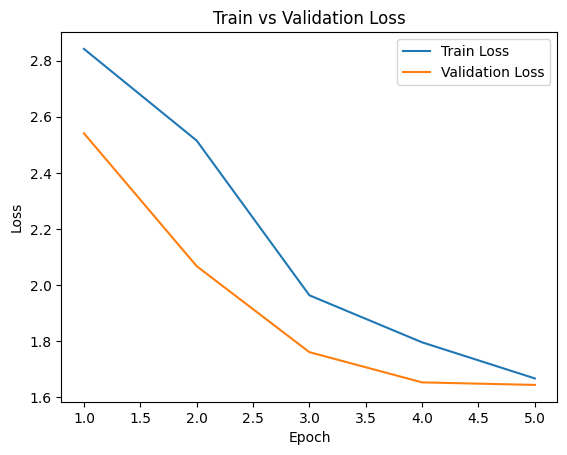

In [63]:
import matplotlib.pyplot as plt

plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()


### Validating the test dataset

In [66]:
test_metrics = eval_epoch_with_metrics(model, test_loader)

print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"LOB Accuracy: {test_metrics['lob_accuracy']:.4f}")
print(f"LOB Macro-F1: {test_metrics['lob_macro_f1']:.4f}")
print(f"Coverage Accuracy: {test_metrics['coverage_accuracy']:.4f}")
print(f"Coverage Macro-F1: {test_metrics['coverage_macro_f1']:.4f}")



Test Loss: 1.4950
LOB Accuracy: 1.0000
LOB Macro-F1: 1.0000
Coverage Accuracy: 0.3962
Coverage Macro-F1: 0.2061


### Saving the model to a folder, used for inference

In [ ]:


BASE_DIR = "model_artifacts1"
MODEL_DIR = os.path.join(BASE_DIR, "model")
ENCODER_DIR = os.path.join(MODEL_DIR, "encoder")
TOKENIZER_DIR = os.path.join(BASE_DIR, "tokenizer")

os.makedirs(ENCODER_DIR, exist_ok=True)
os.makedirs(TOKENIZER_DIR, exist_ok=True)

# Save full model weights
torch.save(model.state_dict(), os.path.join(MODEL_DIR, "model_full.pt"))

# Save encoder config + weights
model.encoder.save_pretrained(ENCODER_DIR)

# Save tokenizer
tokenizer.save_pretrained(TOKENIZER_DIR)

# Save label maps
with open(os.path.join(BASE_DIR, "lob_label_map.json"), "w") as f:
    json.dump(lob_map, f, indent=2)

with open(os.path.join(BASE_DIR, "coverage_label_maps.json"), "w") as f:
    json.dump(coverage_label_maps, f, indent=2)

print("All artifacts saved successfully")
